In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32,
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [4]:
len(dataset)


68

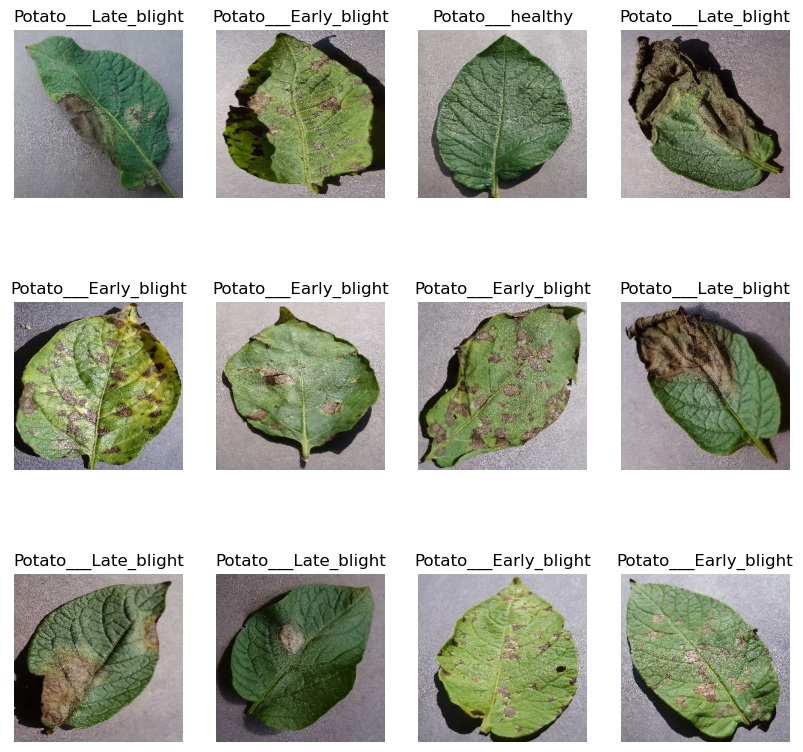

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])



In [12]:
def dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = dataset_partition(dataset)

In [14]:
len(train_ds)

54

In [15]:
len(val_ds)

6

In [16]:
len(test_ds)

8

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(256, 256),
    tf.keras.layers.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

"""    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidthZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeightZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomCrop(256, 256)"""


'    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomWidthZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomHeightZoom(0.2),\n    tf.keras.layers.experimental.preprocessing.RandomCrop(256, 256)'

In [28]:
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=input_shape)



In [29]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [30]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=50,
          batch_size=32,
          verbose=1)

Epoch 1/50
54/54 [==============================] - 17s 134ms/step - loss: 0.8958 - accuracy: 0.5168 - val_loss: 0.8210 - val_accuracy: 0.7031
Epoch 2/50
54/54 [==============================] - 7s 120ms/step - loss: 0.6602 - accuracy: 0.6985 - val_loss: 0.4612 - val_accuracy: 0.8021
Epoch 3/50
54/54 [==============================] - 6s 117ms/step - loss: 0.4470 - accuracy: 0.7928 - val_loss: 0.3647 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 6s 117ms/step - loss: 0.3722 - accuracy: 0.8524 - val_loss: 0.4040 - val_accuracy: 0.8333
Epoch 5/50
54/54 [==============================] - 6s 116ms/step - loss: 0.3395 - accuracy: 0.8617 - val_loss: 0.3252 - val_accuracy: 0.8542
Epoch 6/50
54/54 [==============================] - 6s 117ms/step - loss: 0.2319 - accuracy: 0.9161 - val_loss: 0.3294 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 6s 117ms/step - loss: 0.2114 - accuracy: 0.9201 - val_loss: 0.8496 - val_accuracy: 0.7240
Epoch

In [32]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 1s 18ms/step - loss: 0.0527 - accuracy: 0.9844


In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()




dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']



[0.5167824029922485,
 0.6984953880310059,
 0.7928240895271301,
 0.8524305820465088,
 0.8616898059844971,
 0.9160879850387573,
 0.9201388955116272,
 0.9438657164573669,
 0.9357638955116272,
 0.9519675970077515,
 0.9675925970077515,
 0.9675925970077515,
 0.9600694179534912,
 0.9467592835426331,
 0.9675925970077515,
 0.9739583134651184,
 0.9768518805503845,
 0.9704861044883728,
 0.9803240895271301,
 0.9768518805503845,
 0.9814814925193787,
 0.9803240895271301,
 0.9855324029922485,
 0.9739583134651184,
 0.9907407164573669,
 0.984375,
 0.9837962985038757,
 0.9855324029922485,
 0.9837962985038757,
 0.9895833134651184,
 0.9809027910232544,
 0.9797453880310059,
 0.9890046119689941,
 0.9901620149612427,
 0.984375,
 0.9780092835426331,
 0.9918981194496155,
 0.9924768805503845,
 0.9913194179534912,
 0.9942129850387573,
 0.9762731194496155,
 0.9814814925193787,
 0.9814814925193787,
 0.9878472089767456,
 0.9942129850387573,
 0.9924768805503845,
 0.9901620149612427,
 0.9918981194496155,
 0.983796298

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']





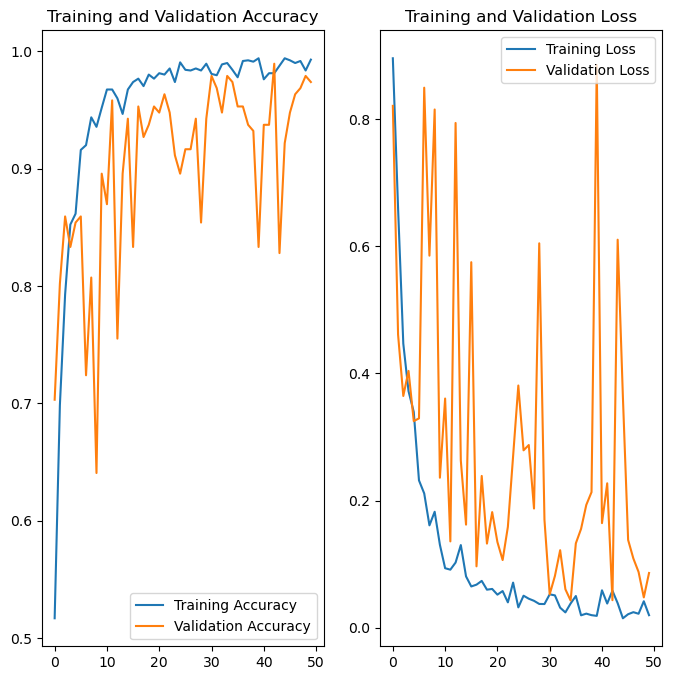

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


First image to predict
Actual lable:  Potato___Late_blight
1/1 [==============================] - 0s 84ms/step
Predicted lable:  Potato___Late_blight


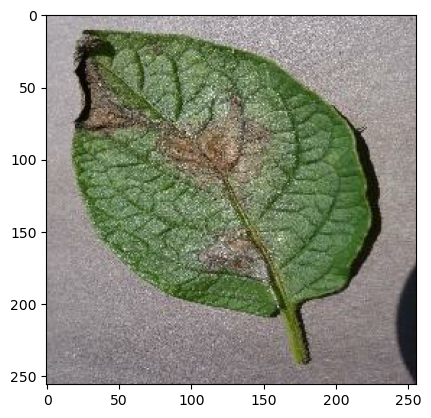

In [38]:
import numpy as np
for image_batch, label_batch in test_ds.take(1):
    first_image = (image_batch[0].numpy().astype("uint8"))
    first_lable = label_batch[0].numpy()

    print("First image to predict")

    plt.imshow(first_image)
    print("Actual lable: ", class_names[first_lable])
    #print(class_names[first_lable])

    batch_prediction = model.predict(image_batch)
    print("Predicted lable: ", class_names[np.argmax(batch_prediction[0])])




In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence




1/1 [==============================] - 0s 13ms/step


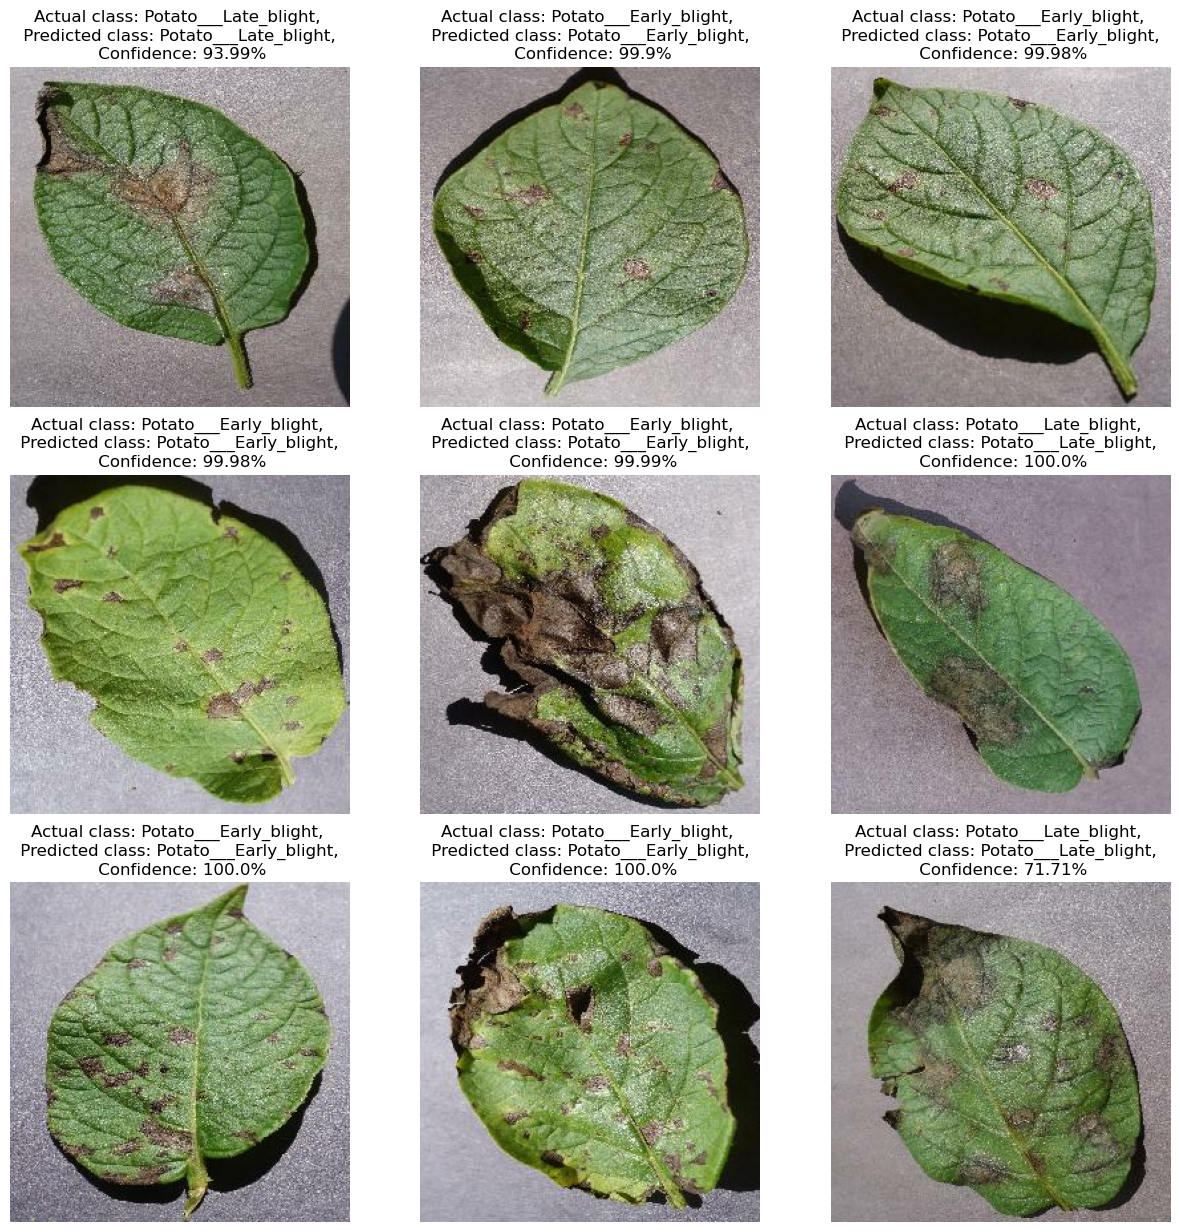

In [40]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")




In [41]:
model_version = "Potato_Model_v1.00"
model.save(f"../Models/{model_version}")
model.save(f"../Models/{model_version}.h5")



INFO:tensorflow:Assets written to: ../Models/Potato_Model_v1.00\assets


INFO:tensorflow:Assets written to: ../Models/Potato_Model_v1.00\assets
